<a href="https://colab.research.google.com/github/mkuczynski11/iui-project/blob/master/IUI_project_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notatnik do projektu z IUI - Klasyfikacja dokumentów prawnych z wizualizacją za pomocą algorytmu SOM

### Importowanie bibliotek i danych

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, string
import shutil

# text-preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
shutil.copyfile('./drive/MyDrive/IUI/stop_words.txt', '/root/nltk_data/corpora/stopwords/polish')
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
!pip install morfeusz2
import morfeusz2

# model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('./drive/MyDrive/IUI/dbdata.csv', encoding='Windows-1250')
df.head()

,id,sample,label
0,0,czy wspólnota mieszkaniowa może podjąć uchwałę...,prawo cywilne
1,1,czy wspólnota mieszkaniowa może odzyskać pomie...,prawo cywilne
2,2,czy uprawnienie mieszkańców wspólnoty mieszkan...,prawo administracyjne
3,3,czy budowa windy dla osób niepełnosprawnych mo...,prawo administracyjne
4,4,jakie czynności powinna podjąć wspólnota miesz...,prawo cywilne


### Eksploracja danych

#### Dystybucja klas

[Text(0, 0, 'prawo cywilne'),
 Text(1, 0, 'prawo administracyjne'),
 Text(2, 0, 'prawo farmaceutyczne'),
 Text(3, 0, 'prawo pracy'),
 Text(4, 0, 'prawo medyczne'),
 Text(5, 0, 'prawo karne'),
 Text(6, 0, 'inne'),
 Text(7, 0, 'prawo podatkowe')]

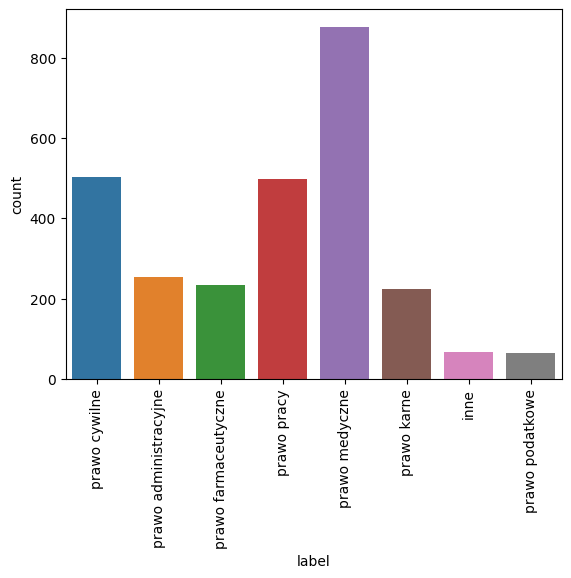

In [ ]:
g = sns.countplot(x = 'label', data = df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#### Wartości brakujące

In [ ]:
print(df.isna().sum())
print(f'Samples before cleanup: {len(df)}')
df = df[df['sample'].notnull()]
print(f'Samples after removing null sample values: {len(df)}')

id        0
sample    2
label     0
dtype: int64
Samples before cleanup: 2721
Samples after removing null sample values: 2719


### Pre-processing dokumentów

#### Usunięcie znaków specjalnych itp.

In [ ]:
# zamiana liter na małe, usunięcie dodatkowych spacji, usunięcie interpunkcji
def preprocess(text):
  text = text.lower()
  text = text.strip()
  text = re.compile('<.*?>').sub('', text)
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub(r'\[[0-9]*\]',' ',text)
  text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
  text = re.sub(r'\d',' ',text)
  text = re.sub(r'\s+',' ',text)
  return text

### Usunięcie stop-words

In [ ]:
# usunięcie słów ze słownika stop-words
def stopword_removal(string):
  a= [i for i in string.split() if i not in stopwords.words('polish')]
  return ' '.join(a)

### Lemmatization

In [ ]:
morf = morfeusz2.Morfeusz()
def lemmatizer(string):
  text = ""
  for word in string.split():
    analysis = morf.analyse(word)
    text = text + analysis[0][2][1].split(':')[0] + " "
  return text[:-2]

#### Rezultat pre-processingu

In [ ]:
def finalpreprocess(string):
  return lemmatizer(stopword_removal(preprocess(string)))

In [ ]:
df['clean_sample'] = df['sample'].apply(lambda x: finalpreprocess(x))
df.head()

,id,sample,label,clean_sample
0,0,czy wspólnota mieszkaniowa może podjąć uchwałę...,prawo cywilne,wspólnota mieszkaniowy podjąć uchwała dotyczyć...
1,1,czy wspólnota mieszkaniowa może odzyskać pomie...,prawo cywilne,wspólnota mieszkaniowy odzyskać pomieścić gosp...
2,2,czy uprawnienie mieszkańców wspólnoty mieszkan...,prawo administracyjne,uprawnić mieszkaniec wspólnota mieszkaniowy zg...
3,3,czy budowa windy dla osób niepełnosprawnych mo...,prawo administracyjne,budowa winda osoba niepełnosprawny zostać zakw...
4,4,jakie czynności powinna podjąć wspólnota miesz...,prawo cywilne,czynność podjąć wspólnota mieszkaniowy założen...


### Trenowanie modelu klasyfikacji dokumentów

#### Splity danych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_sample"],df["label"],test_size=0.2,shuffle=True)

#### Model z wykorzystaniem danych zwektorayzowanych na podstawie bag-of-words

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_vectors_tfidf[0].shape

(1, 4149)

In [ ]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.80      0.36      0.50        11
prawo administracyjne       0.60      0.43      0.50        49
        prawo cywilne       0.70      0.80      0.74       115
 prawo farmaceutyczne       0.78      0.71      0.75        56
          prawo karne       0.43      0.28      0.34        36
       prawo medyczne       0.71      0.77      0.74       171
      prawo podatkowe       0.14      0.10      0.12        10
          prawo pracy       0.75      0.82      0.79        96

             accuracy                           0.70       544
            macro avg       0.62      0.53      0.56       544
         weighted avg       0.69      0.70      0.69       544

Confusion Matrix: [[  4   0   1   1   0   4   0   1]
 [  0  21   9   1   4   9   1   4]
 [  0   7  92   2   7   5   0   2]
 [  0   0   3  40   0   8   1   4]
 [  0   1  10   0  10  12   0   3]
 [  1   2  13   6   2 132   3  12]
 [  0   2   2

In [ ]:
from sklearn import svm
svm_tfidf = svm.SVC(probability=True)
svm_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = svm_tfidf.predict(X_test_vectors_tfidf)
y_prob = svm_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.00      0.00      0.00        11
prawo administracyjne       0.77      0.20      0.32        49
        prawo cywilne       0.74      0.83      0.78       115
 prawo farmaceutyczne       0.80      0.66      0.73        56
          prawo karne       0.54      0.19      0.29        36
       prawo medyczne       0.61      0.88      0.72       171
      prawo podatkowe       0.33      0.10      0.15        10
          prawo pracy       0.82      0.80      0.81        96

             accuracy                           0.69       544
            macro avg       0.58      0.46      0.48       544
         weighted avg       0.69      0.69      0.66       544

Confusion Matrix: [[  0   0   0   1   0  10   0   0]
 [  0  10  13   1   1  21   0   3]
 [  0   2  95   2   4  10   0   2]
 [  0   0   2  37   0  14   0   3]
 [  0   0  10   0   7  17   0   2]
 [  0   0   6   4   1 151   2   7]
 [  0   0   1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import tree
tree_tfidf = tree.DecisionTreeClassifier()
tree_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = tree_tfidf.predict(X_test_vectors_tfidf)
y_prob = tree_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.00      0.00      0.00        11
prawo administracyjne       0.35      0.39      0.37        49
        prawo cywilne       0.75      0.66      0.70       115
 prawo farmaceutyczne       0.67      0.70      0.68        56
          prawo karne       0.36      0.36      0.36        36
       prawo medyczne       0.64      0.64      0.64       171
      prawo podatkowe       0.11      0.10      0.11        10
          prawo pracy       0.67      0.75      0.71        96

             accuracy                           0.60       544
            macro avg       0.44      0.45      0.45       544
         weighted avg       0.60      0.60      0.60       544

Confusion Matrix: [[  0   2   1   2   1   4   0   1]
 [  0  19   8   3   1  11   2   5]
 [  2  12  76   2   9   8   1   5]
 [  0   1   1  39   2   5   2   6]
 [  0   5   3   2  13  12   0   1]
 [  4   9  12   8   9 109   3  17]
 [  0   3   1

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_tfidf = SGDClassifier(loss="log_loss", penalty="l2", max_iter=5)
sgd_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = sgd_tfidf.predict(X_test_vectors_tfidf)
y_prob = sgd_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.75      0.27      0.40        11
prawo administracyjne       0.65      0.41      0.50        49
        prawo cywilne       0.73      0.82      0.77       115
 prawo farmaceutyczne       0.80      0.71      0.75        56
          prawo karne       0.45      0.28      0.34        36
       prawo medyczne       0.70      0.81      0.75       171
      prawo podatkowe       0.14      0.10      0.12        10
          prawo pracy       0.78      0.83      0.80        96

             accuracy                           0.71       544
            macro avg       0.62      0.53      0.55       544
         weighted avg       0.70      0.71      0.70       544

Confusion Matrix: [[  3   0   0   1   0   6   0   1]
 [  0  20  10   1   4   9   1   4]
 [  0   6  94   2   6   5   0   2]
 [  0   0   3  40   0   8   1   4]
 [  0   1   8   0  10  15   0   2]
 [  1   2  10   5   2 138   3  10]
 [  0   0   2

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_tfidf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 8), random_state=1)
mlp_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = mlp_tfidf.predict(X_test_vectors_tfidf)
y_prob = mlp_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.18      0.18      0.18        11
prawo administracyjne       0.33      0.43      0.38        49
        prawo cywilne       0.70      0.63      0.66       115
 prawo farmaceutyczne       0.49      0.41      0.45        56
          prawo karne       0.32      0.36      0.34        36
       prawo medyczne       0.73      0.65      0.69       171
      prawo podatkowe       0.00      0.00      0.00        10
          prawo pracy       0.65      0.78      0.71        96

             accuracy                           0.59       544
            macro avg       0.42      0.43      0.43       544
         weighted avg       0.59      0.59      0.59       544

Confusion Matrix: [[  2   0   1   3   0   2   1   2]
 [  2  21   8   1   4   5   1   7]
 [  3  22  73   5   7   1   0   4]
 [  0   2   5  23  11  10   1   4]
 [  0   3   6   2  13  10   1   1]
 [  4   7   9  11   5 112   2  21]
 [  0   2   2

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<!-- ### Przygotowanie danych do SOM -->

In [ ]:
all_vectors = tfidf_vectorizer.transform(df['clean_sample'])
all_predictions = lr_tfidf.predict_proba(all_vectors)
W = np.array(all_predictions)
W = (W - np.mean(W, axis=0)) / np.std(W, axis=0)
W[0]

array([-0.24474067, -0.28214803,  2.45851521, -0.33946157, -0.29860134,
       -0.90853382, -0.17850332, -0.59708528])

### Self Organising Map dokumentów z minisom DONE

In [ ]:
!pip install minisom
from minisom import MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=69871777dbef13ca7f5a3c0d558132cca0dc81e659fad5c539512764f9b52dca
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [ ]:
import math
n_neurons = 16 # 5*math.sqrt(len(W))
m_neurons = 16 # 5*math.sqrt(len(W))
som = MiniSom(x=n_neurons, y=m_neurons, input_len=len(W[0]), sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=5)
# som.pca_weights_init(W)
som.train_batch(W, len(W)*10, verbose=True)

 [ 27190 / 27190 ] 100% - 0:00:00 left 
 quantization error: 0.2151478505346859


In [ ]:
som_x = []
som_y = []
for i in range(len(W)):
  w = som.winner(W[i])
  som_x.append(w[0])
  som_y.append(w[1])

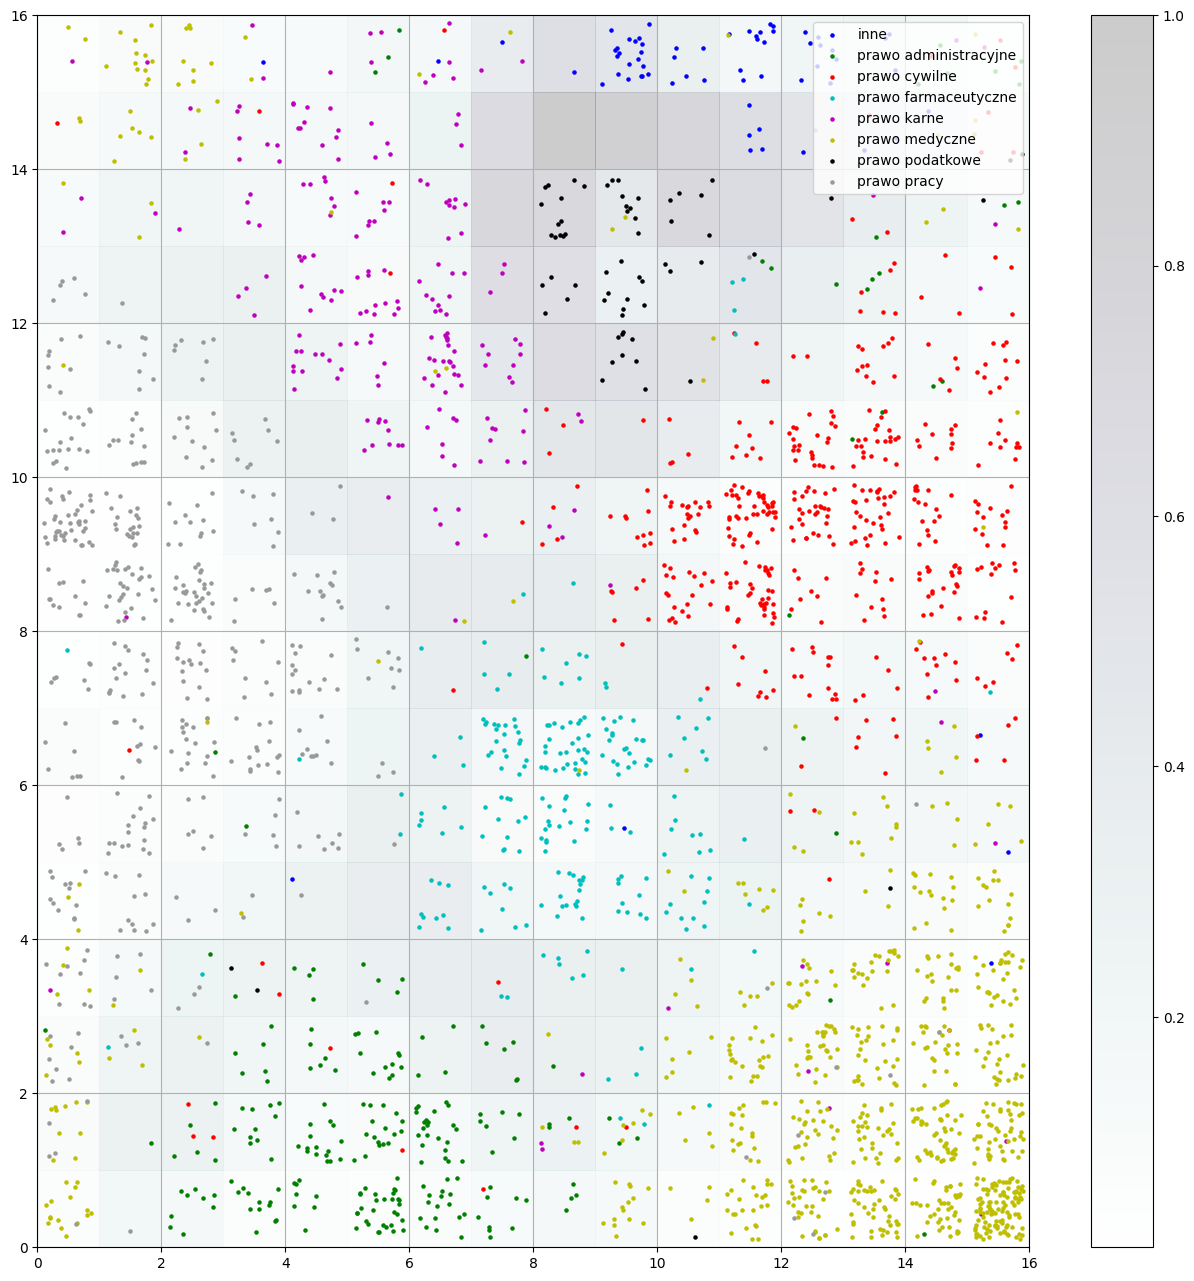

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(n_neurons,m_neurons))

plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

target = df['label'].values
w_x = np.array(som_x)
w_y = np.array(som_y)
colors = {
    'inne': 'b',
    'prawo administracyjne': 'g',
    'prawo cywilne': 'r',
    'prawo farmaceutyczne': 'c',
    'prawo karne': 'm',
    'prawo medyczne': 'y',
    'prawo podatkowe': 'k',
    'prawo pracy': '0.6'
}
for c in np.unique(target):
  idx_target = target == c
  plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*0.8,
              w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*0.8,
              s=5, c=colors[c], label=c)
plt.legend(loc='upper right')
plt.grid()
plt.savefig('som_documents.png')
plt.show()
# df.head(40)